In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


데이터 가져오기

In [ ]:
!unzip "/content/drive/MyDrive/multicampus/cats_and_dogs.zip" -d "/content"

device 셋팅

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')



개와 고양이 이미지 데이터 셋이 주어졌고, 이 둘을 분류하는 모델을 만들어야 한다. -> 강아지 4천장, 고양이 4천장 그리고 검증 데이터 각각 1천장씩 주어졌다.

In [4]:
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_image

커스텀 이미지 데이터셋 클래스 생성

In [5]:
class CustomImageDataset(Dataset):
  def __init__(self, image_dir, transform=None):
    self.image_dir = image_dir
    self.img_labels = pd.read_csv(f"{image_dir}/label.csv")
    self.transform = transform

  # 전체 데이터 셋의 크기
  def __len__(self):
    return len(self.img_labels)

  # 데이터 리턴
  def __getitem__(self, idx):
    image_path = f"{self.image_dir}/{self.img_labels.iloc[idx, 0]}"
    image = read_image(image_path)
    if self.transform:
      image = self.transform(image)
    label = self.img_labels.iloc[idx, 1]
    return image, label

In [6]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transform = weights.transforms()

### 데이터셋, 데이터 로더 준비

In [7]:
train_dataset = CustomImageDataset("./cats_and_dogs/train", transform=transform)
val_dataset = CustomImageDataset("./cats_and_dogs/test", transform=transform)

In [8]:
import pandas as pd

label_df = pd.read_csv("/content/cats_and_dogs/train/label.csv")
label_df

,filepath,label
0,cats/cat_0001.jpg,0
1,cats/cat_0002.jpg,0
2,cats/cat_0003.jpg,0
3,cats/cat_0004.jpg,0
4,cats/cat_0005.jpg,0
...,...,...
7995,dogs/dog_3996.jpg,1
7996,dogs/dog_3997.jpg,1
7997,dogs/dog_3998.jpg,1
7998,dogs/dog_3999.jpg,1


<Axes: xlabel='label'>

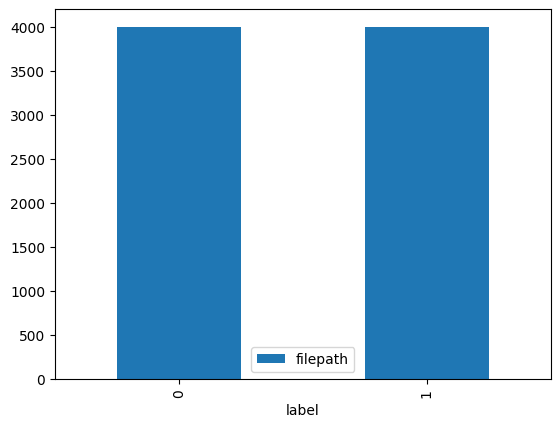

In [ ]:
label_df.groupby("label").count().plot(kind="bar")

accuracy로 성능 판단해도 될 듯!

In [ ]:
train_dataset[0][0].numpy()

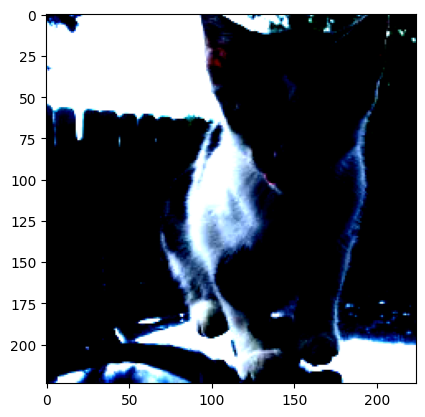

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(train_dataset[10][0].numpy().transpose(1, 2, 0))

### 데이터로더 생성

#### batch_size(배치 사이즈) 변경 여기야!

In [9]:
from torch.utils.data import DataLoader

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
from matplotlib import pyplot as plt

def plot_batch(batch, label_dict, cmap=None):
    img_tensor_batch = batch[0]
    label_batch = batch[1]
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img_tensor = img_tensor_batch[i]
        img_array = img_tensor.numpy().transpose(1, 2, 0)
        ax.imshow(img_array, cmap=cmap)
        ax.set_title(f"{label_dict[label_batch[i].item()]}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


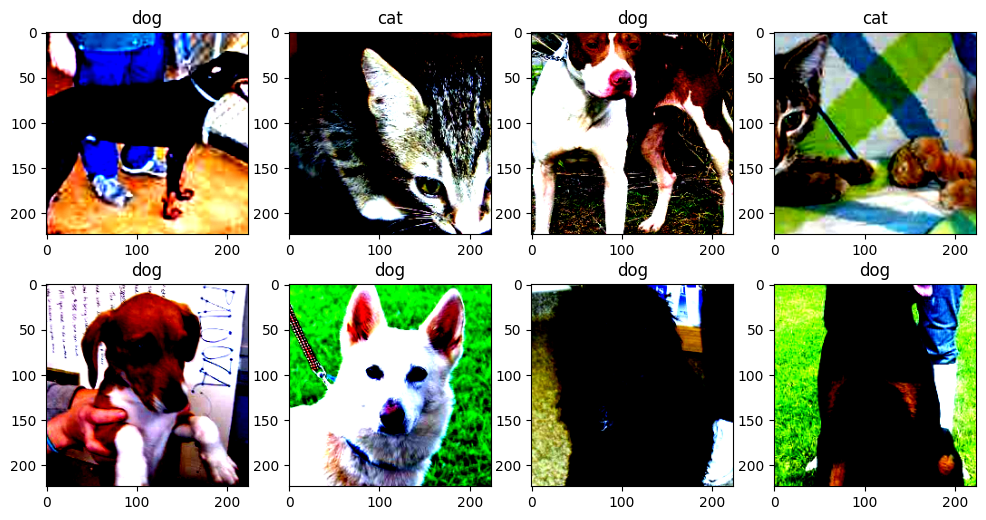

In [11]:
label_dict = {0: "cat", 1: "dog"}
for batch in train_dataloader:
  plot_batch(batch, label_dict)
  break

### 모델 학습 코드

In [12]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [13]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = ((y_train == pred).sum() / len(y_train)).item()
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [14]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(val_dataloader):
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = ((y_val == pred).sum() / len(y_val)).item()
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [15]:
from collections import defaultdict


def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [16]:
def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

### 모델 준비

torch에 내장된 resnet18 모델을 불러와서 마지막 fc layer를 2진 분류에 맞게 교체해준다.

In [17]:
model = resnet18().to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

마지막 레이어가 1000개의 클래스로 분류하도록 설정되어 있는데,
우리는 개와 고양이 2개로만 분류할 예정이기 때문에 out_features를 0과 1, 총 2개로 만들어야 한다.

In [18]:
model = resnet18()
model.fc = torch.nn.Linear(in_features=512, out_features=2)
model = model.to(device)

In [20]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

## 방법1. 마지막 FC layer만 학습
전체 모델 weight는 고정한 채로 FC layer만 새로 교체한 뒤에 학습 진행

In [21]:
model = resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


In [ ]:
# fc layer를 제외한 다른 layer들은 학습되지 않도록 얼림
for param in model.parameters():
  param.requires_grad = False

# fc를 우리 데이터셋에 맞게 교체
model.fc = torch.nn.Linear(in_features=512, out_features=2)
model = model.to(device)

In [ ]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

파라미터 설정

In [25]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
epochs = 3

In [ ]:
logs = train_validate_model(model)

 19%|█▉        | 6/32 [03:50<16:38, 38.39s/it]


KeyboardInterrupt: 

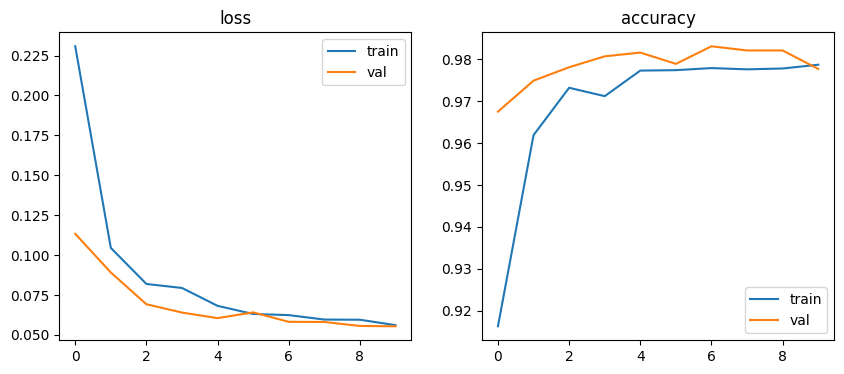

In [ ]:
plot_logs(logs)

In [ ]:
acc_mean = sum(logs["val_acc"]) / len(logs["val_acc"])
acc_mean

0.9786700000000002

batch size=128, epoch=10 일때 평균 validation accuracy = 0.9787(반올림해서 약 97.9%)


## 방법2. 뒷 단의 컨볼루션 레이어, FC 레이어만 튜닝
전체 모델 파라미터 얼림, 학습을 적용할 레이어만 풀어주고 학습 진행

In [22]:
model = resnet18(weights=weights)

In [24]:
# 학습되지 않도록 얼림
for param in model.parameters():
  param.requires_grad = False

# layer 3만 학습되도록 한다
for param in model.layer3.parameters():
  param.requires_grad = True

# layer 4만 학습되도록 한다
for param in model.layer4.parameters():
  param.requires_grad = True

# fc를 데이터셋에 맞게 교체
model.fc = torch.nn.Linear(in_features=512, out_features=2)
model = model.to(device)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
logs = train_validate_model(model)

  0%|          | 0/63 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 16/16 [03:39<00:00, 13.74s/it]


epoch 1 train - loss: 0.1283 acc: 0.9509 val - loss: 0.1097 acc: 0.9556


 41%|████▏     | 26/63 [10:51<15:27, 25.06s/it]


KeyboardInterrupt: 

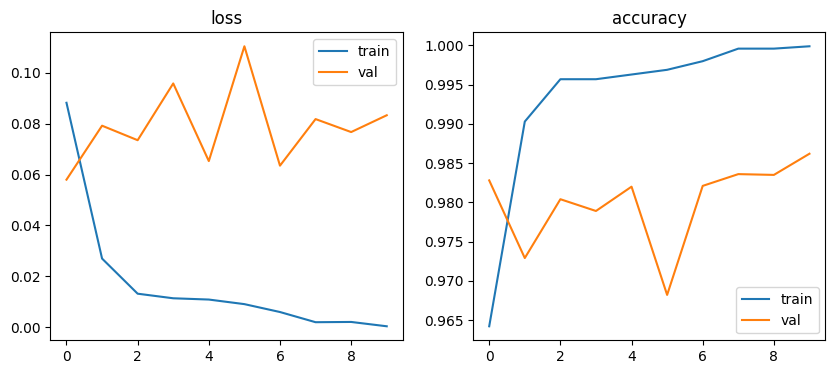

In [ ]:
plot_logs(logs)

In [ ]:
max(logs["val_acc"])

0.9862

In [ ]:
val_acc = sum(logs["val_acc"]) / len(logs["val_acc"])
val_acc

0.9800599999999999

지금까지 성능에서는 마지막 컨볼루션 레이어와 fc 레이어를 학습시켰을 때 가장 좋았다. 이제 조금 더 경량화된 efficientNet을 이용하여 모델을 학습시키고 ResNet과 결과를 비교해 보겠다.